# Sales Demand Forecasting using SARIMAX
# Time Series Analysis Project

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Loading and Preprocessing


In [5]:
#loading the data
file_path = 'Month_Value_1.csv'
# Load the dataset into a DataFrame
df = pd.read_csv('Month_Value_1.csv')
month = pd.read_csv('Month_Value_1.csv')
df = pd.read_csv('Month_Value_1.csv')
month.head(5)

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [6]:
df['Period'] = pd.to_datetime(df['Period'])
df.set_index('Period', inplace=True)

In [7]:
df.interpolate(method='linear', inplace=True)

In [8]:
df = df[['Sales_quantity', 'Revenue', 'Average_cost',
         'The_average_annual_payroll_of_the_region']]

## present trend

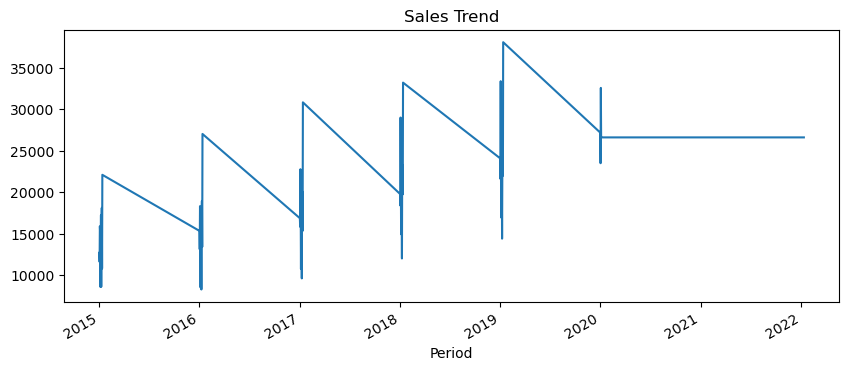

In [9]:
import matplotlib.pyplot as plt
df['Sales_quantity'].plot(figsize=(10,4), title="Sales Trend")
plt.show()

## Stationarity Check (ADF Test)


In [10]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df['Sales_quantity'])
print("ADF:", adf[0])
print("p-value:", adf[1])

ADF: -1.4541339047979907
p-value: 0.556066474561828


In [11]:
# First-order differencing
df['Sales_diff'] = df['Sales_quantity'].diff()
# Remove NaN created by differencing
df.dropna(inplace=True)

In [12]:
from statsmodels.tsa.stattools import adfuller
adf_diff = adfuller(df['Sales_diff'])
print("ADF Statistic (Differenced):", adf_diff[0])
print("p-value (Differenced):", adf_diff[1])

ADF Statistic (Differenced): -6.686657134333799
p-value (Differenced): 4.2094278589827585e-09


In [13]:
# Time-based train-test split (NO random split)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (76, 5)
Test size: (19, 5)


## SARIMAX Model Development


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(
    train['Sales_quantity'],
    exog=train[['Revenue',
                'Average_cost',
                'The_average_annual_payroll_of_the_region']],
    order=(1, 1, 1),   # p=1, d=1, q=1
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Sales_quantity   No. Observations:                   76
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -598.020
Date:                Sat, 03 Jan 2026   AIC                           1208.040
Time:                        19:28:58   BIC                           1221.783
Sample:                             0   HQIC                          1213.517
                                 - 76                                         
Covariance Type:                  opg                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Revenue                                      0.0006   1.25e-05     46.244      0.000       0.001       0.001
Average_cost                             

In [15]:
# Number of test observations
n_test = len(test)
# Forecast using steps instead of index
test_forecast_obj = model_fit.get_forecast(
    steps=n_test,
    exog=test[['Revenue',
               'Average_cost',
               'The_average_annual_payroll_of_the_region']]
)
# Extract predicted values
test_forecast = test_forecast_obj.predicted_mean
print(test_forecast.head())

76    26776.021550
77    26772.062434
78    26772.159778
79    26772.157385
80    26772.157444
Name: predicted_mean, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(test['Sales_quantity'], test_forecast)
rmse = np.sqrt(mean_squared_error(test['Sales_quantity'], test_forecast))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 157.35593604377019
RMSE: 157.35830941856864


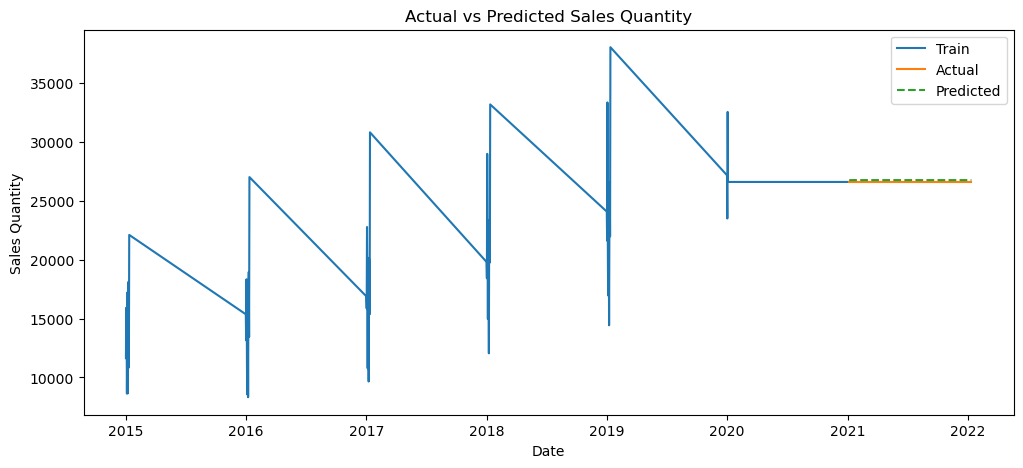

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Sales_quantity'], label='Train')
plt.plot(test.index, test['Sales_quantity'], label='Actual')
plt.plot(test.index, test_forecast, label='Predicted', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title("Actual vs Predicted Sales Quantity")
plt.legend()
plt.show()

In [18]:
# Number of months to forecast (2 years)
n_future = 24
# Create future dates (monthly)
future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=n_future,
    freq='MS'
)
print(future_dates)

DatetimeIndex(['2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01'],
              dtype='datetime64[ns]', freq='MS')


In [19]:
# Last known values
last_revenue = df['Revenue'].iloc[-1]
last_cost = df['Average_cost'].iloc[-1]
last_payroll = df['The_average_annual_payroll_of_the_region'].iloc[-1]
# Monthly growth assumptions (realistic)
revenue_growth = 0.01     # 1% per month
cost_growth = 0.005       # 0.5% per month
payroll_growth = 0.003    # 0.3% per month
# Generate future exogenous variables
future_exog = pd.DataFrame(index=future_dates)
future_exog['Revenue'] = [
    last_revenue * ((1 + revenue_growth) ** i)
    for i in range(1, n_future + 1)
]
future_exog['Average_cost'] = [
    last_cost * ((1 + cost_growth) ** i)
    for i in range(1, n_future + 1)
]
future_exog['The_average_annual_payroll_of_the_region'] = [
    last_payroll * ((1 + payroll_growth) ** i)
    for i in range(1, n_future + 1)
]
print(future_exog.head())

                 Revenue  Average_cost  \
2022-03-01  5.284390e+07   1975.663964   
2022-04-01  5.337234e+07   1985.542284   
2022-05-01  5.390606e+07   1995.469995   
2022-06-01  5.444512e+07   2005.447345   
2022-07-01  5.498957e+07   2015.474582   

            The_average_annual_payroll_of_the_region  
2022-03-01                              2.913213e+07  
2022-04-01                              2.921953e+07  
2022-05-01                              2.930719e+07  
2022-06-01                              2.939511e+07  
2022-07-01                              2.948329e+07  


In [20]:
# Forecast future Sales Quantity (or target variable)
future_forecast = model_fit.get_forecast(
    steps=n_future,
    exog=future_exog
)
# Extract predicted mean
future_pred = future_forecast.predicted_mean
# Attach correct datetime index
future_pred.index = future_dates
print(future_pred.head())

2022-03-01    26954.339374
2022-04-01    27131.127066
2022-05-01    27314.427511
2022-06-01    27500.112107
2022-07-01    27688.310931
Freq: MS, Name: predicted_mean, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


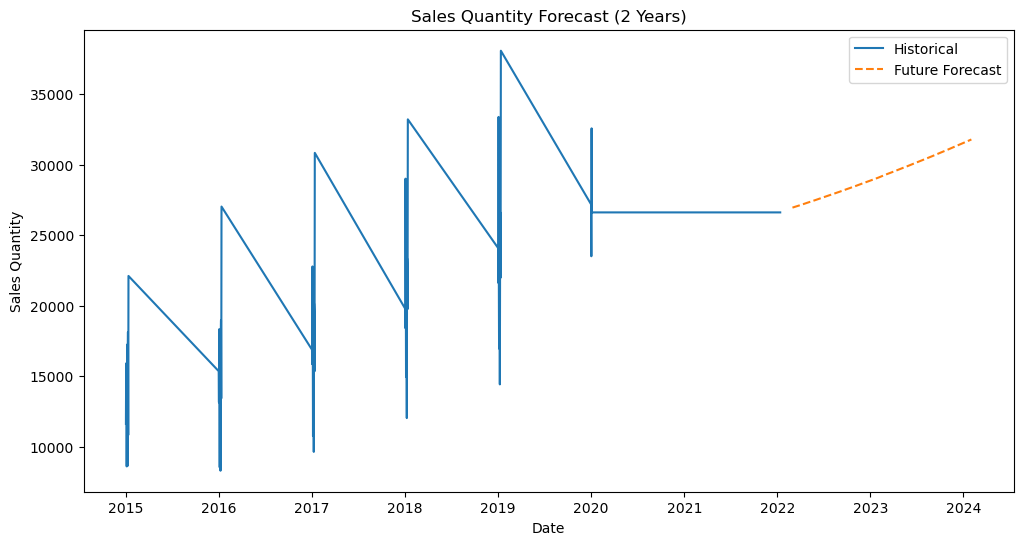

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df['Sales_quantity'], label='Historical')
plt.plot(future_pred, label='Future Forecast', linestyle='--')
plt.title('Sales Quantity Forecast (2 Years)')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()